# Cloud radar data collected on MS Merian

## General information
From here you can access the W band radar data collected on the RV MSMerian. The radar is a frequency modulated continuous-wave (FMCW) 94 GHz dual polarization radar (manufactured by RPG GmbH) and the data are published on AERIS. The data presented here are corrected for ship motions. For more details on the algorithm applied for correction, please check the paper in preparation in ESSD.

It measured continously during the campaign, with a time resolution of 3 seconds and vertical range resolution varying with height between 7.5, 9.2 and 30 m. Here we provide you with some tools to plot and visualize the data.   
A [**quicklook browser**](https://bit.ly/2QpsAzh) is helping you to pick the case you are more interested in. If you have questions or if you would like to use the data for a publication, please don't hesitate to get in contact with the dataset author that you can find [here](https://doi.org/10.25326/156).

### Getting the data catalog

The python code below allows you to browse through the days avaiable

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use(["./mplstyle/book", "./mplstyle/wide"])
import numpy as np
import eurec4a
cat = eurec4a.get_intake_catalog()

### Getting the data from the MS-Merian ship
To visualize which datasets are available for the MS-Merian ship, type:

In [2]:
list(cat['MS-Merian'])

['track', 'FMCW94_RPG']

### Check available days of Wband radar data
To check which days are available from the Wband radar dataset, type:

In [3]:
for key, source in cat['MS-Merian']['FMCW94_RPG'].items():
    desc = source.describe()
    user_parameters = desc.get("user_parameters", [])
    if len(user_parameters) > 0:
        params = " (" + ", ".join(p["name"] for p in user_parameters) + ")"
    else:
        params = ""
    print(f"{key}{params}: {desc['description']}")
    for parameter in user_parameters:
        print(f"    {parameter['name']}: {parameter['min']} ... {parameter['max']} default: {parameter['default']}")

motion_corrected (date): daily ship motion corrected Wband radar data
    date: 2020-01-19 00:00:00 ... 2020-02-19 14:00:00 default: 2020-01-19 20:00:00


### Selecting one day for plot/visualization
To work on a specific day, please provide the date as input in the form "yyyy-mm-dd hh:mm" as a field to date in the code below.
```{note}
The datetime type accepts multiple values: Python datetime, ISO8601 string, Unix timestamp int, “now” and “today”.
```

In [4]:
date = '2020-01-27 13:00' # <--- provide the date here 
ds = cat['MS-Merian']['FMCW94_RPG'].motion_corrected(date=date).to_dask()
ds

<xarray.Dataset>
Dimensions:                (height: 550, time: 26719)
Coordinates:
  * time                   (time) datetime64[ns] 2020-01-27T00:00:01 ... 2020...
  * height                 (height) float32 104.4 111.8 ... 9.949e+03 9.983e+03
    lat                    (time) float32 ...
    lon                    (time) float32 ...
Data variables:
    rain_rate              (time) float32 ...
    relative_humidity      (time) float32 ...
    air_temperature        (time) float32 ...
    air_pressure           (time) float32 ...
    wind_speed             (time) float32 ...
    wind_direction         (time) float32 ...
    liquid_water_path      (time) float32 ...
    instrument             |S64 ...
    mean_doppler_velocity  (time, height) float32 ...
    radar_reflectivity     (time, height) float32 ...
    spectral_width         (time, height) float32 ...
    skewness               (time, height) float32 ...
Attributes: (12/28)
    CREATED_BY:        Claudia Acquistapace
    CREATED_ON:        2021-04-21 12:41:53.521894
    FILL_VALUE:        NaN
    PI_NAME:           Claudia Acquistapace
    PI_AFFILIATION:    University of Cologne (UNI), Germany
    PI_ADDRESS:        Institute for geophysics and meteorology, Pohligstrass...
    ...                ...
    COMMENT:           daily files reduced for eurec4a intake book tool, not ...
    Conventions:       CF-1.8
    title:             hourly MRR measurements on Maria S. Merian (msm) ship ...
    institution:       University of Cologne - Germany
    history:           source: wband data postprocessed\nprocessing: ship mot...
    featureType:       trajectoryProfile

### Plot some radar quantities
To create time/height plots for radar moments, pick a variable name having dimension `(time, height)` from the list of data variables and type the name in the code below. The example here is for mean Doppler velocity (corrected for ship motions). You can decide to either select the entire day or a given hour by providing `time_min` and `time_max`.
To provide time_min and time_max, modify the string 'yyyy-mm-ddThh:mm:ss'
Example:
to select the entire day :
```python
time_min = np.datetime64('2020-01-27T00:00:00')
time_max = np.datetime64('2020-01-27T23:59:59')
```

to select between 13:00 and 15:00 UTC:

```python
time_min = np.datetime64('2020-01-27T13:00:00')
time_max = np.datetime64('2020-01-27T15:00:00')
```

In [5]:
# set min and max time values for plotting along the x-axis
time_min = np.datetime64('2020-01-27T13:00:00') # insert the string value corresponding to t_min
time_max = np.datetime64('2020-01-27T15:00:00') # insert the string value corresponding to t_max

# selecting subset of data
ds_sliced = ds.sel(time=slice(time_min, time_max))

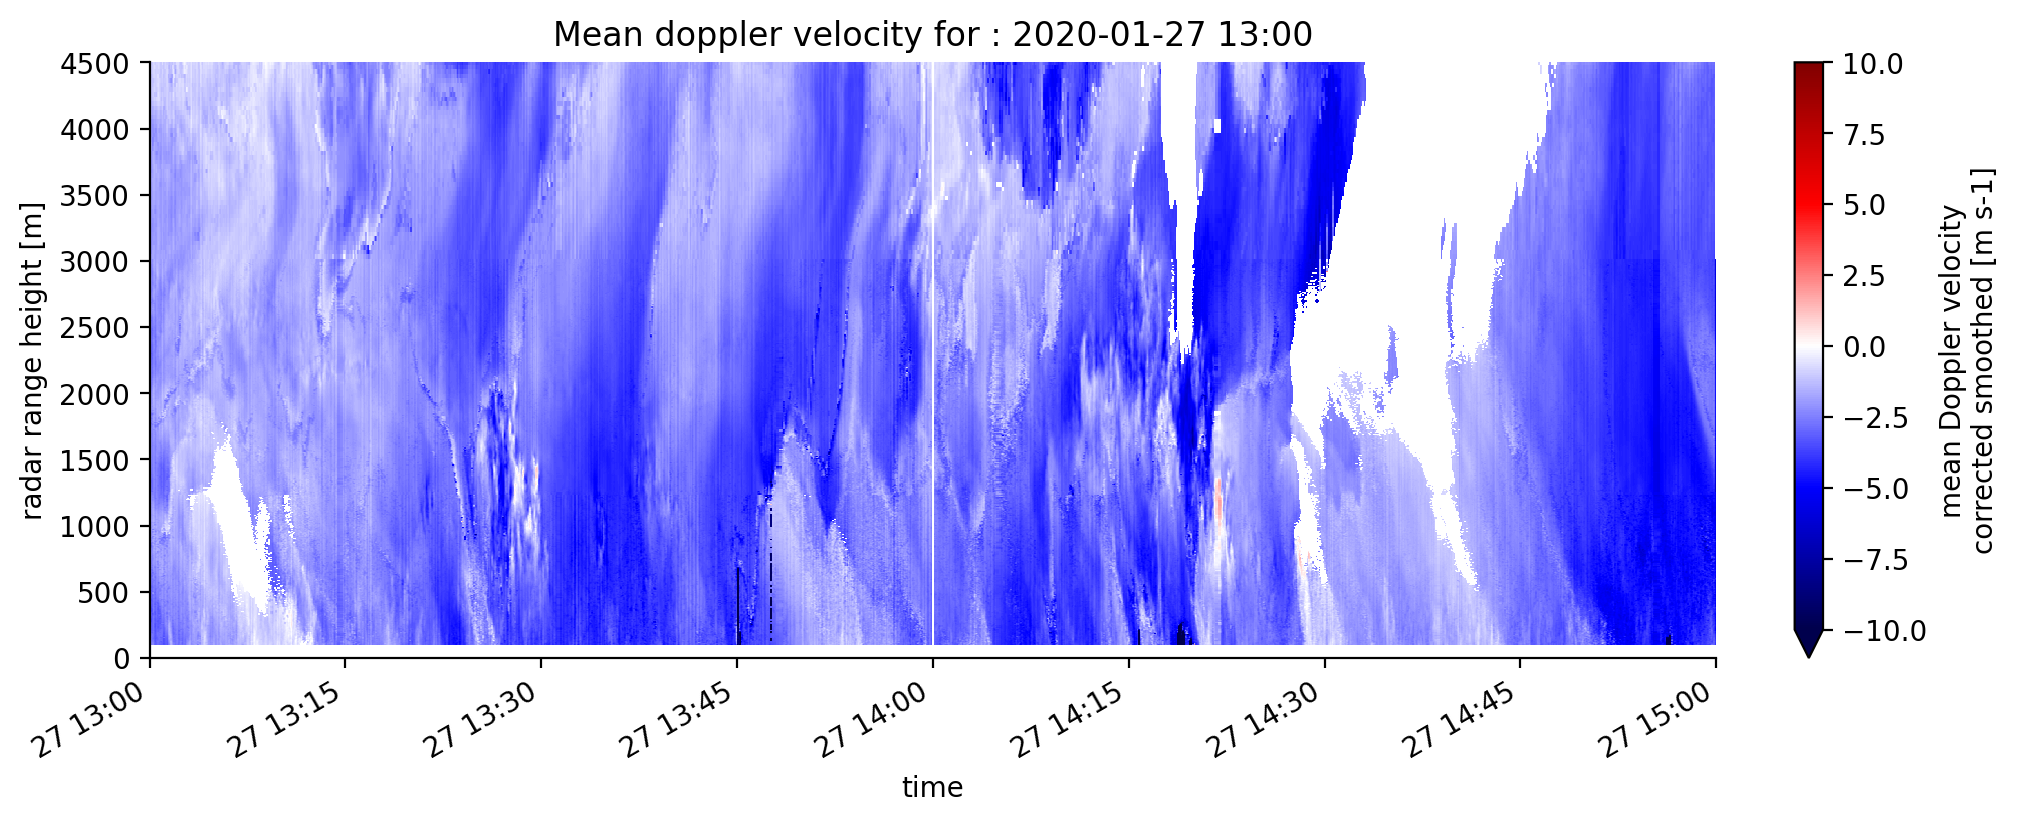

In [6]:
fig, ax = plt.subplots()
# set here the variable from ds to plot, its color map and its min and max values
ds_sliced.mean_doppler_velocity.plot(x='time', y='height', cmap="seismic", vmin=-10., vmax=10.)
ax.set_title("Mean doppler velocity for : "+date)
ax.set_xlim(time_min, time_max)
ax.set_ylim(0, 4500);

### Check corresponding merian position in the selected hour
We use the function `track2layer` defined in the {doc}`flight_tracks_leaflet` chapter, and we provide as input the data for the time interval selected during the day

In [7]:
import ipyleaflet

# function to associate features to a given track
def track2layer(track, color="green", name=""):
    return ipyleaflet.Polyline(
        locations=np.stack([track.lat.values, track.lon.values], axis=1).tolist(), 
        color=color,
        fill=True,
        weight=4,
        name=name
    )

# definition of the base map 
m = ipyleaflet.Map(
    basemap=ipyleaflet.basemaps.Esri.NatGeoWorldMap,
    center=(11.3, -57), zoom=6)
m.add_layer(track2layer(ds_sliced, 'red', 'merian position'))  # adding layer of merian position
m.add_control(ipyleaflet.ScaleControl(position='bottomleft'))
m.add_control(ipyleaflet.LayersControl(position='topright'))
m.add_control(ipyleaflet.FullScreenControl())
display(m)

Map(center=[11.3, -57], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_…